In [1]:
import numpy as np
from cwSaab import cwSaab
from cross_entropy import Cross_Entropy
from lag import LAG
from llsr import LLSR as myLLSR
from pixelhop2 import Pixelhop2
from saab import Saab
import data
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import pickle

Using TensorFlow backend.
/Users/manmacbp/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/manmacbp/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/manmacbp/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/manmacbp/opt/anaconda3/lib/p

In [2]:
from sklearn import datasets
from skimage.util import view_as_windows
from skimage.measure import block_reduce
import skimage.measure
import skimage

In [3]:
def Shrink(X, shrinkArg):
    win = shrinkArg['win']
    stride = shrinkArg['stride']
    MaxPooling = shrinkArg['MaxPooling'] 
    #hop = shrinkArg['hop']
    ch=X.shape[-1]
    X = view_as_windows(np.ascontiguousarray(X), (1,win,win,ch), (1,stride,stride,ch))
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], -1)
    
    if MaxPooling < 3:
    
        X = skimage.measure.block_reduce(X, (1,2,2,1), np.max)
    return X

def Concat(X, concatArg):
    return X


In [4]:
# read data
import cv2

In [5]:
train_images, train_labels, test_images, test_labels, class_list = data.import_data("0-9")
print('Training image size:', train_images.shape)
print('Testing_image size:', test_images.shape)

Training image size: (50000, 32, 32, 3)
Testing_image size: (10000, 32, 32, 3)


In [6]:
# set args
SaabArgs = [{'num_AC_kernels':-1, 'needBias':False, 'useDC':True, 'batch':None, 'cw':False}, 
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw':True}, 
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'batch':None, 'cw':True}]
shrinkArgs = [{'func':Shrink, 'win':5,'stride': 1, 'MaxPooling':1}, 
            {'func': Shrink, 'win':5,'stride': 1, 'MaxPooling': 1},
            {'func': Shrink, 'win':5,'stride': 1, 'MaxPooling': 2}]

concatArg = {'func':Concat}



In [7]:
X = train_images
print("input feature shape: %s"%str(X.shape))

input feature shape: (50000, 32, 32, 3)


In [8]:
from skimage.util import view_as_windows

In [9]:
start_module1=time.time() #starting the time
start=time.time()

In [10]:
print(" -----> Starting:")
p2 = Pixelhop2(depth=3, TH1=0.001, TH2=0.0001, SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg)
p2.fit(X)
output = p2.transform(X)
print(output[0].shape, output[1].shape, output[2].shape)
print("------- Training DONE -------\n")



 -----> Starting:
pixelhop2 fit
pixelhop2 transform
(50000, 14, 14, 41) (50000, 5, 5, 216) (50000, 1, 1, 498)
------- Training DONE -------



In [55]:
stop_module1=time.time()
total_module1=stop_module1 -start_module1

In [12]:
# save data
fw=open('pixelhop_train.pkl','wb')    
pickle.dump(output, fw)    
fw.close()

In [13]:
#to load

output = pickle.load(open('pixelhop_train.pkl', 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(loaded_model)

In [14]:
output_test = p2.transform(test_images)
print(output_test[0].shape, output_test[1].shape, output_test[2].shape)
print("------- Testing DONE -------\n")



pixelhop2 transform
(10000, 14, 14, 41) (10000, 5, 5, 216) (10000, 1, 1, 498)
------- Testing DONE -------



In [15]:
# save data
fw=open('pixelhop_test.pkl','wb')    
pickle.dump(output_test, fw)    
fw.close()



In [16]:
#to load

output_test = pickle.load(open('pixelhop_test.pkl', 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(loaded_model)

In [17]:
#Module2

In [18]:
start_module2_1= time.time()

In [19]:
train_images, train_labels, test_images, test_labels, class_list = data.import_data("0-9")
out1 = output[0]
out2 = output[1]
out3 = output[2]
feature1 = out1.reshape((out1.shape[0], -1))
print("input feature shape 1: %s"%str(feature1.shape))
feature2 = out2.reshape((out2.shape[0], -1))
print("input feature shape 2: %s"%str(feature2.shape))
feature3 = out3.reshape((out3.shape[0], -1))
print("input feature shape 3: %s"%str(feature3.shape))

ce = Cross_Entropy(num_class=10, num_bin=5)

feature_ce_1 = np.zeros(feature1.shape[-1])
for k1 in range(feature1.shape[-1]):
    feature_ce_1[k1] = ce.KMeans_Cross_Entropy(feature1[:,k1].reshape(-1,1), train_labels)
    #print(" --> KMeans ce: %s"%str(feature_ce_1[k]))
print("------- 1 DONE -------\n")

feature_ce_2 = np.zeros(feature2.shape[-1])
for k2 in range(feature2.shape[-1]):
    feature_ce_2[k2] = ce.KMeans_Cross_Entropy(feature2[:,k2].reshape(-1,1), train_labels)
    #print(" --> KMeans ce: %s"%str(feature_ce_1[k]))
print("------- 2 DONE -------\n")

feature_ce_3 = np.zeros(feature3.shape[-1])
for k3 in range(feature3.shape[-1]):
    feature_ce_3[k3] = ce.KMeans_Cross_Entropy(feature3[:,k3].reshape(-1,1), train_labels)
    #print(" --> KMeans ce: %s"%str(feature_ce_1[k]))
print("------- 3 DONE -------\n")

input feature shape 1: (50000, 8036)
input feature shape 2: (50000, 5400)
input feature shape 3: (50000, 498)
------- 1 DONE -------

------- 2 DONE -------

------- 3 DONE -------



In [20]:
fw=open('feature_ce_1.pkl','wb')    
pickle.dump(feature_ce_1, fw)    
fw.close()


In [21]:
#to load

feature_ce_1 = pickle.load(open('feature_ce_1.pkl', 'rb'))

In [22]:
fw=open('feature_ce_2.pkl','wb')    
pickle.dump(feature_ce_2, fw)    
fw.close()



In [23]:
#to load

feature_ce_2 = pickle.load(open('feature_ce_2.pkl', 'rb'))

In [24]:
fw=open('feature_ce_3.pkl','wb')    
pickle.dump(feature_ce_3, fw)    
fw.close()

In [25]:
#to load

feature_ce_3 = pickle.load(open('feature_ce_3.pkl', 'rb'))



In [26]:
#sort
N=1000
ce_sorted_1=feature_ce_1.argsort()[:N]
ce_sorted_2=feature_ce_2.argsort()[:N]
ce_sorted_3=feature_ce_3.argsort()[:N]


In [27]:
#training


#1
feature_out_1 = out1.reshape(out1.shape[0],-1)
print('feature_out_1', feature_out_1.shape)
minimum_1 = min(N, feature_out_1.shape[-1] )
feature_Select_1 = np.zeros((feature_out_1.shape[0],minimum_1))
print('feature_Select_1', feature_Select_1.shape)

a=1
for i in ce_sorted_1:

    if a < minimum_1:
        feature_Select_1[:,a] = feature_out_1[:,i]
        a = a+1
        
    if a == N:
        exit
        

#2
feature_out_2=out2.reshape(out2.shape[0],-1)
print('feature_out_2', feature_out_2.shape)
minimum_2=min(N, feature_out_2.shape[-1] )
feature_Select_2=np.zeros((feature_out_2.shape[0],minimum_2))
print('feature_Select_2', feature_Select_2.shape)

b=1
for i in ce_sorted_2:

    if b < minimum_2:
        feature_Select_2[:,b] = feature_out_2[:,i]
        b = b+1
        
    if b == N:
        exit
        

#3
feature_out_3=out3.reshape(out3.shape[0],-1)
print('feature_out_3', feature_out_3.shape)
minimum_3=min(N, feature_out_3.shape[-1] )
feature_Select_3=np.zeros((feature_out_3.shape[0],minimum_3))
print('feature_Select_3', feature_Select_3.shape)

c=1
for i in ce_sorted_3:

    if c < minimum_3:
        feature_Select_3[:,c] = feature_out_3[:,i]
        c = c+1
        
    if c == N:
        exit
        

feature_out_1 (50000, 8036)
feature_Select_1 (50000, 1000)
feature_out_2 (50000, 5400)
feature_Select_2 (50000, 1000)
feature_out_3 (50000, 498)
feature_Select_3 (50000, 498)


In [28]:
stop_module2_1= time.time()

In [29]:
#test

outTest_1=output_test[0]
outTest_2=output_test[1]
outTest_3=output_test[2]

#1
feature_test_out_1 = outTest_1.reshape(outTest_1.shape[0],-1)
print('feature_test_out_1', feature_test_out_1.shape)
minimum_test_1 = min(N, feature_test_out_1.shape[-1] )
feature_test_Select_1 = np.zeros((feature_test_out_1.shape[0],minimum_test_1))
print('feature_test_Select_1', feature_test_Select_1.shape)

a=1
for i in ce_sorted_1:

    if a < minimum_test_1:
        feature_test_Select_1[:,a] = feature_test_out_1[:,i]
        a = a+1
        
    if a == N:
        exit
        

#2
feature_test_out_2=outTest_2.reshape(outTest_2.shape[0],-1)
print('feature_test_out_2', feature_test_out_2.shape)
minimum_test_2=min(N, feature_test_out_2.shape[-1] )
feature_test_Select_2=np.zeros((feature_test_out_2.shape[0],minimum_test_2))
print('feature_test_Select_2', feature_test_Select_2.shape)

b=1
for i in ce_sorted_2:

    if b < minimum_test_2:
        feature_test_Select_2[:,b] = feature_test_out_2[:,i]
        b = b+1
        
    if b == N:
        exit
        

#3
feature_test_out_3=outTest_3.reshape(outTest_3.shape[0],-1)
print('feature_test_out_3', feature_test_out_3.shape)
minimum_test_3=min(N, feature_test_out_3.shape[-1] )
feature_test_Select_3=np.zeros((feature_test_out_3.shape[0],minimum_test_3))
print('feature_test_Select_3', feature_test_Select_3.shape)

c=1
for i in ce_sorted_3:

    if c < minimum_test_3:
        feature_test_Select_3[:,c] = feature_test_out_3[:,i]
        c = c+1
        
    if c == N:
        exit
        



feature_test_out_1 (10000, 8036)
feature_test_Select_1 (10000, 1000)
feature_test_out_2 (10000, 5400)
feature_test_Select_2 (10000, 1000)
feature_test_out_3 (10000, 498)
feature_test_Select_3 (10000, 498)


In [30]:
start_module2_2= time.time()

In [31]:
lag = LAG(encode='distance', num_clusters=[5,5,5,5,5,5,5,5,5,5], alpha=10, learner=myLLSR(onehot=False))  
#1
lag.fit(feature_Select_1, train_labels) 
train_images_trans_1 = lag.transform(feature_Select_1)
test_images_tran_1s = lag.transform(feature_test_Select_1)
train_images_predprob_1 = lag.predict_proba(feature_Select_1)
print(" --> train acc for Hop 1: %s"%str(lag.score(feature_Select_1, train_labels)))
print(" --> test acc for Hop 1: %s"%str(lag.score(feature_test_Select_1, test_labels)))
print("------- 1 DONE -------\n")

#2
lag.fit(feature_Select_2, train_labels) 
train_images_trans_2 = lag.transform(feature_Select_2)
test_images_trans_2 = lag.transform(feature_test_Select_2)
train_images_predprob_2 = lag.predict_proba(feature_Select_2)
print(" --> train acc for Hop 2: %s"%str(lag.score(feature_Select_2, train_labels)))
print(" --> test acc for Hop 2: %s"%str(lag.score(feature_test_Select_2, test_labels)))
print("------- 2 DONE -------\n")

#3
lag.fit(feature_Select_3, train_labels) 
train_images_trans_3 = lag.transform(feature_Select_3)
test_images_trans_3 = lag.transform(feature_test_Select_3)
train_images_predprob_3 = lag.predict_proba(feature_Select_3)
print(" --> train acc for Hop 3: %s"%str(lag.score(feature_Select_3, train_labels)))
print(" --> test acc for Hop 3: %s"%str(lag.score(feature_test_Select_3, test_labels)))
print("------- 3 DONE -------\n")

 --> train acc for Hop 1: 0.4378
 --> test acc for Hop 1: 0.385
------- 1 DONE -------

 --> train acc for Hop 2: 0.61404
 --> test acc for Hop 2: 0.5728
------- 2 DONE -------

 --> train acc for Hop 3: 0.59584
 --> test acc for Hop 3: 0.5732
------- 3 DONE -------



In [32]:
stop_module2_2= time.time()

start_modul2=start_module2_1+start_module2_2
stop_module2=stop_module2_1+stop_module2_2
total_module2=stop_module2-start_modul2

In [33]:
start_modul3=time.time()

In [1]:
#combine LAG
LAG_train_units_comibined = np.concatenate ((train_images_trans_1, train_images_trans_2, train_images_trans_3), axis = 1)
LAG_test_units_comibined = np.concatenate ((test_images_tran_1s, test_images_trans_2, test_images_trans_3), axis = 1)
print('LAG_train_units_comibined', LAG_train_units_comibined.shape)
print('LAG_test_units_comibined', LAG_test_units_comibined.shape)

NameError: name 'np' is not defined

In [35]:
stop=time.time()
time_elapsed=stop-start
print('time_elapsed in s', time_elapsed)
minutes=time_elapsed/60
print('time_elapsed in minutes', minutes)

time_elapsed in s 3455.731246948242
time_elapsed in minutes 57.5955207824707


In [36]:
print(len(LAG_train_units_comibined))
print(len(train_labels))
print(len(LAG_test_units_comibined))
print(len(test_labels))

50000
50000
10000
10000


In [37]:
reg=myLLSR(onehot=True, normalize=False)
reg.fit(LAG_train_units_comibined, train_labels)
train_reg=reg.predict_proba(LAG_train_units_comibined)

print(" --> train acc for with reg: %s"%str(reg.score(LAG_train_units_comibined, train_labels)))
print(" --> test acc for with reg: %s"%str(reg.score(LAG_test_units_comibined, test_labels)))

print("------- DONE -------\n")

 --> train acc for with reg: 0.6449
 --> test acc for with reg: 0.5933
------- DONE -------



In [38]:
#Module 3

In [39]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification        

In [40]:
scaler=preprocessing.StandardScaler()
feature = scaler.fit_transform(LAG_train_units_comibined) 
feature_test = scaler.transform(LAG_test_units_comibined)   

In [52]:
clf=RandomForestClassifier(n_estimators=500,max_depth=20).fit(feature, train_labels) 
print('***** Training Accuracy with RF:', accuracy_score(train_labels,clf.predict(feature)))
print('***** Test Accuracy with RF:', accuracy_score(test_labels,clf.predict(feature_test)))

/Users/manmacbp/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


***** Training Accuracy with RF: 0.98406
***** Test Accuracy with RF: 0.6385


In [42]:
clf_svm=SVC().fit(feature, train_labels) 
print('***** Training Accuracy with SVM:', accuracy_score(train_labels,clf_svm.predict(feature)))
print('***** Test Accuracy with SVM:', accuracy_score(test_labels,clf_svm.predict(feature_test)))

/Users/manmacbp/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


***** Training Accuracy with SVM: 0.8133
***** Test Accuracy with SVM: 0.6712


In [44]:
stop_module3=time.time()
total_module3=stop_module3-start_modul3

total_training_time=total_module1+total_module2+total_module3

In [54]:
print ('total_time_module1 in S:', total_module1)
print ('total_time_module2 in S:', total_module2)
print ('total_time_module3 in S:', total_module3)
print('total_training_timein S:', total_training_time)
print ('total_time_module1 in min:', total_module1/60)
print ('total_time_module2 in min:', total_module2/60)
print ('total_time_module3 in min:', total_module3/60)
print('total_training_timein min:', total_training_time/60)


total_time_module1 in S: 990.3697690963745
total_time_module2 in S: 2409.2200508117676
total_time_module3 in S: 2116.625561952591
total_training_timein S: 5516.215381860733
total_time_module1 in min: 16.50616281827291
total_time_module2 in min: 40.15366751352946
total_time_module3 in min: 35.27709269920985
total_training_timein min: 91.93692303101221


In [45]:
#b) Error analysis

In [46]:
#confusion matrix without normalization
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd

confusion matrix without normalization
[[674  36  52  26  24   8  17  11 111  41]
 [ 27 772  10   9  11   5  18  11  38  99]
 [ 81  22 478  75 105  84  78  42  16  19]
 [ 23  31  71 452  60 189  84  33  21  36]
 [ 37  15  86  77 549  33  78  96  22   7]
 [ 14   5  75 177  50 560  35  56  10  18]
 [ 11  19  56  59  53  32 742  12   6  10]
 [ 18  15  29  53  70  81  19 664   7  44]
 [ 67  63  11  17   8  11   9   9 764  41]
 [ 33 118  11  28   8  10  14  23  43 712]]


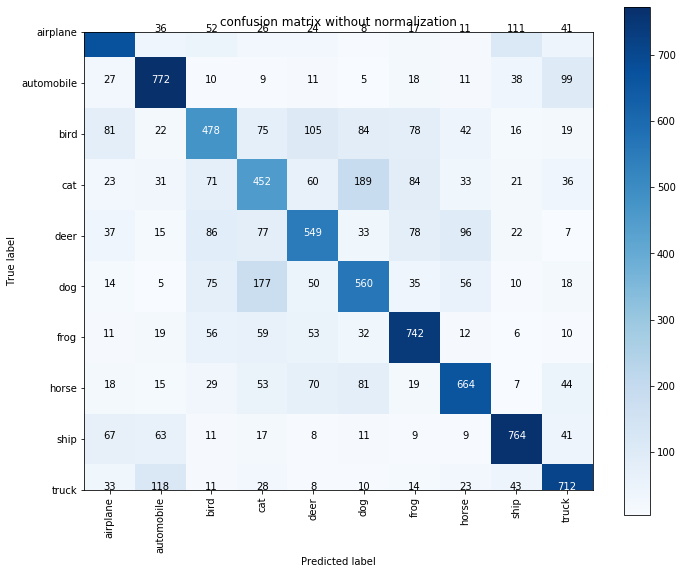

In [47]:
#not normalized
plt.rcParams['figure.figsize'] = [10,8]
#plt.figure(figsize=(10, 6))

test_pred = clf.predict(feature_test)
cmap=plt.cm.Blues
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classifier = clf_svm
cm=confusion_matrix(np.array(test_labels),np.array(test_pred))


plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
title= 'confusion matrix without normalization'

plt.title(title)

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 90)
plt.yticks(tick_marks, classes)


print ('confusion matrix without normalization')
print (cm)

np.set_printoptions(precision=2)



thresh = cm.max() / 2
#thresh = cm.max() / 2
fmt = 'd'
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

  


confusion matrix without normalization
[[677  36  58  23  24  11  15  10 105  41]
 [ 27 778  10   8   9   6  19  10  35  98]
 [ 83  26 475  74  97  85  81  43  16  20]
 [ 26  28  71 466  55 178  83  38  20  35]
 [ 40  12  88  81 547  32  76  93  22   9]
 [ 12   6  75 181  54 554  35  52  12  19]
 [ 10  16  56  58  50  32 748  13   8   9]
 [ 16  13  26  57  71  81  18 667   7  44]
 [ 69  58   7  18   8  11  10  10 765  44]
 [ 32 122  13  26   9  11  12  24  43 708]]


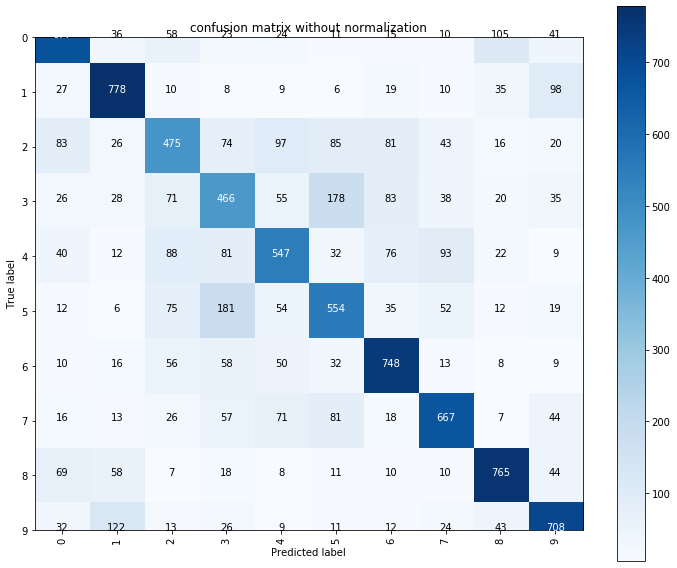

In [58]:
#not normalized
plt.rcParams['figure.figsize'] = [10,8]
#plt.figure(figsize=(10, 6))

test_pred = clf.predict(feature_test)
cmap=plt.cm.Blues
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
classifier = clf_svm
cm=confusion_matrix(np.array(test_labels),np.array(test_pred))


plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
title= 'confusion matrix without normalization'

plt.title(title)

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 90)
plt.yticks(tick_marks, classes)


print ('confusion matrix without normalization')
print (cm)

np.set_printoptions(precision=2)



thresh = cm.max() / 2
#thresh = cm.max() / 2
fmt = 'd'
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

  



confusion matrix with normalization
[[0.68 0.04 0.06 0.02 0.02 0.01 0.01 0.01 0.1  0.04]
 [0.03 0.78 0.01 0.01 0.01 0.01 0.02 0.01 0.04 0.1 ]
 [0.08 0.03 0.47 0.07 0.1  0.09 0.08 0.04 0.02 0.02]
 [0.03 0.03 0.07 0.47 0.06 0.18 0.08 0.04 0.02 0.04]
 [0.04 0.01 0.09 0.08 0.55 0.03 0.08 0.09 0.02 0.01]
 [0.01 0.01 0.07 0.18 0.05 0.55 0.04 0.05 0.01 0.02]
 [0.01 0.02 0.06 0.06 0.05 0.03 0.75 0.01 0.01 0.01]
 [0.02 0.01 0.03 0.06 0.07 0.08 0.02 0.67 0.01 0.04]
 [0.07 0.06 0.01 0.02 0.01 0.01 0.01 0.01 0.77 0.04]
 [0.03 0.12 0.01 0.03 0.01 0.01 0.01 0.02 0.04 0.71]]


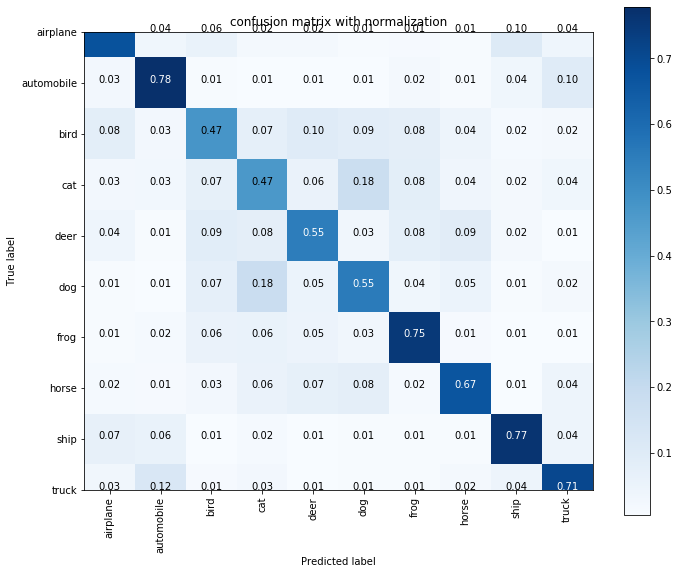

In [57]:
#normalized
plt.rcParams['figure.figsize'] = [10,8]
#plt.figure(figsize=(10, 6))

test_pred = clf.predict(feature_test)
cmap=plt.cm.Blues
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classifier = clf_svm
cm=confusion_matrix(np.array(test_labels),np.array(test_pred))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
title= 'confusion matrix with normalization'
plt.title(title)

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 90)
plt.yticks(tick_marks, classes)


print ('confusion matrix with normalization')
print (cm)

np.set_printoptions(precision=2)



thresh = cm.max() / 1.5
fmt = '.2f' 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

  



confusion matrix with normalization
[[0.68 0.04 0.06 0.02 0.02 0.01 0.01 0.01 0.1  0.04]
 [0.03 0.78 0.01 0.01 0.01 0.01 0.02 0.01 0.04 0.1 ]
 [0.08 0.03 0.47 0.07 0.1  0.09 0.08 0.04 0.02 0.02]
 [0.03 0.03 0.07 0.47 0.06 0.18 0.08 0.04 0.02 0.04]
 [0.04 0.01 0.09 0.08 0.55 0.03 0.08 0.09 0.02 0.01]
 [0.01 0.01 0.07 0.18 0.05 0.55 0.04 0.05 0.01 0.02]
 [0.01 0.02 0.06 0.06 0.05 0.03 0.75 0.01 0.01 0.01]
 [0.02 0.01 0.03 0.06 0.07 0.08 0.02 0.67 0.01 0.04]
 [0.07 0.06 0.01 0.02 0.01 0.01 0.01 0.01 0.77 0.04]
 [0.03 0.12 0.01 0.03 0.01 0.01 0.01 0.02 0.04 0.71]]


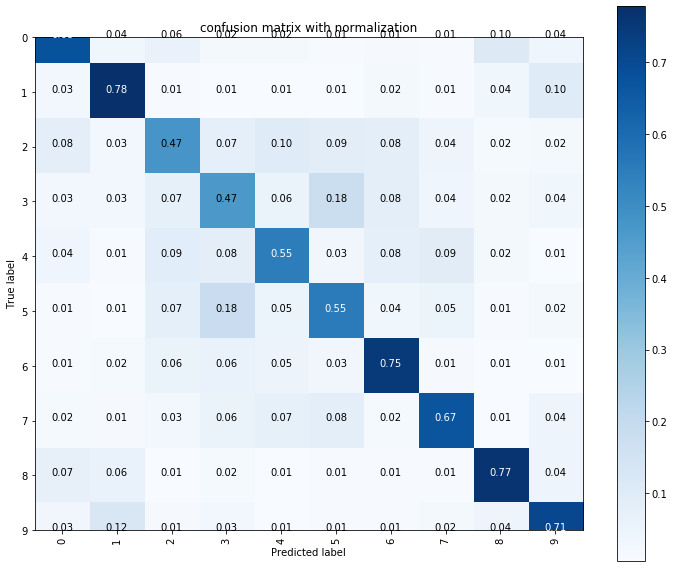

In [59]:
#normalized
plt.rcParams['figure.figsize'] = [10,8]
#plt.figure(figsize=(10, 6))

test_pred = clf.predict(feature_test)
cmap=plt.cm.Blues
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
classifier = clf_svm
cm=confusion_matrix(np.array(test_labels),np.array(test_pred))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
title= 'confusion matrix with normalization'
plt.title(title)

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 90)
plt.yticks(tick_marks, classes)


print ('confusion matrix with normalization')
print (cm)

np.set_printoptions(precision=2)



thresh = cm.max() / 1.5
fmt = '.2f' 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

  




Confusion matrix, without normalization
[[677  36  58  23  24  11  15  10 105  41]
 [ 27 778  10   8   9   6  19  10  35  98]
 [ 83  26 475  74  97  85  81  43  16  20]
 [ 26  28  71 466  55 178  83  38  20  35]
 [ 40  12  88  81 547  32  76  93  22   9]
 [ 12   6  75 181  54 554  35  52  12  19]
 [ 10  16  56  58  50  32 748  13   8   9]
 [ 16  13  26  57  71  81  18 667   7  44]
 [ 69  58   7  18   8  11  10  10 765  44]
 [ 32 122  13  26   9  11  12  24  43 708]]


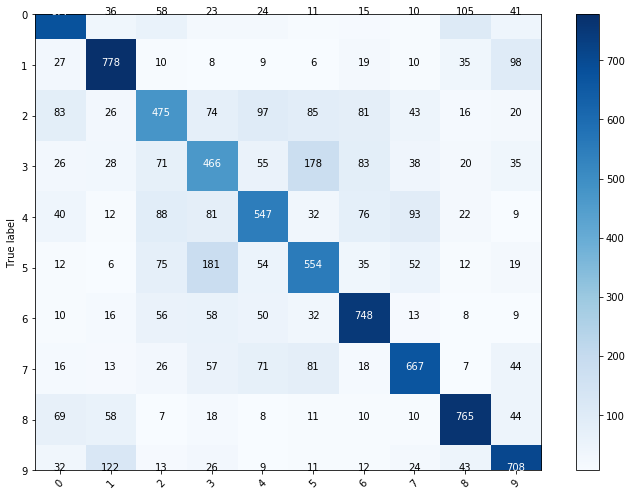

In [66]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
plt.rcParams['figure.figsize'] = [10,7]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)



  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  #plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  #plt.xlabel('Predicted label')
  plt.show()
#classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# clf.predict(feature_test)
p_test = clf.predict(feature_test)
# clf.predict(lags1).argmax(axis=0)
cm = confusion_matrix(test_labels, p_test)
plot_confusion_matrix(cm, list(range(10)))